<a href="https://colab.research.google.com/github/Abishethvarman/FakeNewsDetection/blob/main/FakeNews_Detection_BertBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERTbase on FakeNews Detection
https://youtu.be/LbYF0yMIFaM?si=6oWw52zsMUKU0LgJ
https://drive.google.com/drive/folders/11i95xjTWgr5q2uYwKVITfIXQ595M59-L

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=True.csv

In [1]:
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.5 MB/s eta

In [4]:
##Import packages
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")


In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [7]:
%cd /mydrive/dataset/

/content/gdrive/My Drive/dataset


In [8]:
df_reliable = pd.read_csv("Reliable.csv")
df_fake = pd.read_csv("Fake.csv")

In [10]:
df_reliable['Target'] = ['True']*len(df_reliable)
df_fake['Target'] = ['Fake']*len(df_fake)

In [11]:
df_reliable

,title,text,subject,date,Target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",True


In [ ]:
print(df_reliable['subject'].unique())
print(df_fake['subject'].unique())

['politicsNews' 'worldnews']
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


In [12]:
# df = pd.concat([df_reliable, df_fake]).reset_index(drop = True)
data = df_reliable.append(df_fake).sample(frac=1).reset_index().drop(columns=['index'])


In [13]:
data

,title,text,subject,date,Target
0,Jimmy Kimmel Asks Trump Supporters To Say ONE...,"In the simplest of terms, one way to describe ...",News,"October 28, 2016",Fake
1,IRS GIVES “After School Satan Club” Tax-Exempt...,AFTER SCHOOL SATAN CLUB Allowed By School Dist...,politics,"Mar 17, 2017",Fake
2,"Under threat in Washington, first lady's food ...",NEW YORK (Reuters) - Michelle Obama will be ce...,politicsNews,"December 18, 2016",True
3,Bette Midler Has Theory As To Why People Igno...,It s pretty much common knowledge at this poin...,News,"February 1, 2016",Fake
4,GOTCHA! CLINTON CHARITY “MISFILED” MILLIONS IN...,"What difference does it make? Well, it makes l...",politics,"Apr 23, 2015",Fake
...,...,...,...,...,...
44893,Soldier’s Widow Finally Speaks: ‘It Made Me C...,"Monday morning, things got much worse for Dona...",News,"October 23, 2017",Fake
44894,U.S. diplomatic tiff with Russia should not be...,WASHINGTON (Reuters) - U.S. Secretary of State...,politicsNews,"September 12, 2017",True
44895,Trump administration starts countdown to NAFTA...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"May 18, 2017",True
44896,WHY THE MUELLER ‘WITCH HUNT’ On President Trum...,Special Counsel Robert Mueller s anti-Trump wi...,politics,"Dec 7, 2017",Fake


In [14]:
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,Jimmy Kimmel Asks Trump Supporters To Say ONE...,"In the simplest of terms, one way to describe ...",News,"October 28, 2016",Fake
1,IRS GIVES “After School Satan Club” Tax-Exempt...,AFTER SCHOOL SATAN CLUB Allowed By School Dist...,politics,"Mar 17, 2017",Fake
2,"Under threat in Washington, first lady's food ...",NEW YORK (Reuters) - Michelle Obama will be ce...,politicsNews,"December 18, 2016",True
3,Bette Midler Has Theory As To Why People Igno...,It s pretty much common knowledge at this poin...,News,"February 1, 2016",Fake
4,GOTCHA! CLINTON CHARITY “MISFILED” MILLIONS IN...,"What difference does it make? Well, it makes l...",politics,"Apr 23, 2015",Fake


In [15]:
data['label'] = pd.get_dummies(data.Target)['Fake']

In [17]:
data.head()

,title,text,subject,date,Target,label
0,Jimmy Kimmel Asks Trump Supporters To Say ONE...,"In the simplest of terms, one way to describe ...",News,"October 28, 2016",Fake,1
1,IRS GIVES “After School Satan Club” Tax-Exempt...,AFTER SCHOOL SATAN CLUB Allowed By School Dist...,politics,"Mar 17, 2017",Fake,1
2,"Under threat in Washington, first lady's food ...",NEW YORK (Reuters) - Michelle Obama will be ce...,politicsNews,"December 18, 2016",True,0
3,Bette Midler Has Theory As To Why People Igno...,It s pretty much common knowledge at this poin...,News,"February 1, 2016",Fake,1
4,GOTCHA! CLINTON CHARITY “MISFILED” MILLIONS IN...,"What difference does it make? Well, it makes l...",politics,"Apr 23, 2015",Fake,1


([<matplotlib.patches.Wedge at 0x79b888ec1fc0>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

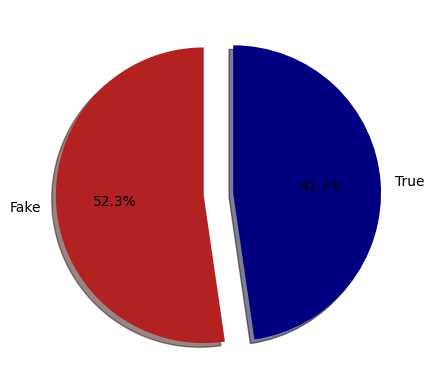

In [18]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [19]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [20]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text(0, 0.5, 'Number of texts')

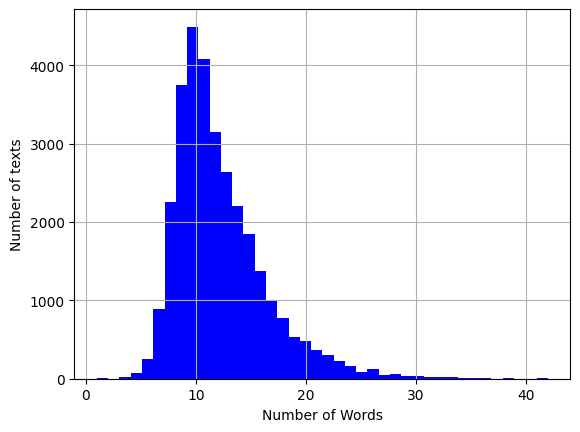

In [23]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [22]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.",
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [24]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [25]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [26]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [27]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

In [29]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [30]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.161
Validation Loss: 0.097

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

In [ ]:
# load weights of best model
path = 'c1_fakenews_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-69995c30edeb>", line 2, in <cell line: 1>
    preds = model(test_seq, test_mask)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-27-e9c3d2ebd56f>", line 11, in forward
    cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return fo

In [33]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 0, 0])